In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image
from IPython.display import display
import textdistance
import time
from glob import glob

from preprocess import Preprocess

In [2]:
class SEARCH_RECOMMEND:
    
    def __init__(self, df, qval=None):
        self.df = df
        self.qval = qval  # Q-Value : 거리 유사도 알고리즘에서 q-gram 으로 문장을 어떻게 나눌지 결정하는 파라미터 (None:단어기반, 1:철자기반, 2~more:q-gram)
        self.df_ = self.preprocess_df(self.df)  # new_tag feature를 새롭게 추가 전처리
        self.user_item_set = set()  # 사용자가 아이템을 선택(검색/추천)시 => 사용자가 선택한 아이템 목록
        self.cold_start = True   # Cold Start : 최적화된 추천 알고리즘 선택을 위해 사용자의 아이템 목록이 비어있는지 확인하는 변수
    
    def preprocess_df(self, df):
        # make new-tag
        # top3_style, tags, name, projectId 를 하나의 string으로 만들기
        df['new_tag'] = list(
                            zip(
                                df['top_style_1'].tolist(), 
                                df['tags'].tolist(),
                                df['name'].tolist(),
                                df['projectId'].tolist()
                                )
                            )
        df['new_tag'] = df['new_tag'].apply(self.reduce_newtag)
        df['new_tag'] = df['new_tag'].apply(lambda x: ' '.join(x).lower())
        return df
    
    def reduce_newtag(self, x):
        newtag = []
        for tag in x:
            if type(tag) == str:
                newtag.append(tag)
            else:
                newtag.extend(tag)
        return newtag
    
    # 사용자 셋에 아이템 추가
    def add_item_in_user_item_set(self, prod):
        print(f'사용자 님의 아이템 목록에 [{prod}]를 추가합니다.')
        id_ = self.df_[self.df_['name'] == prod]['product_id'].values[0]
        self.user_item_set.add(id_)
        self.cold_start = False
        print(f'사용자 님이 현재 선택한 아이템 목록 : {self.user_item_set}')
        return id_
    
    # 사용자 셋에서 아이템 제거
    def remove_item_from_user_item_set(self, prod):
        print(f'사용자 님의 아이템 목록에서 [{prod}]를 제거합니다.')
        id_ = self.df_[self.df_['name'] == prod]['product_id'].values[0]
        self.user_item_set.remove(id_)
        print(f'사용자 님의 현재 남아있는 선택된 아이템 목록 : {self.user_item_set}')
        # 사용자 목록이 비게 되면 콜드스타트
        if len(self.user_item_set) > 1:
            self.cold_start = True
    
    # 사용자가 선택한 아이템과 데이터 내 모든 아이템들과의 유사도 계산
    def get_similarity_score(self, search_prod_tag, algo='sorensen'):
        """
        search_prod_tag : string, 사용자가 선택한 아이템 이름으로부터 매칭된 self.df_['new_tag'].values
        """
        # calculate similarity
        sim_score = []
        new_tag = self.df_['new_tag'].tolist()
        start_time = time.time()
        for i, tag in enumerate(new_tag):
            if algo == 'sorensen':
                sim_score.append(textdistance.Sorensen(qval=self.qval, as_set=True).normalized_similarity(search_prod_tag, tag))
            elif algo == 'ncd':
                sim_score.append(textdistance.EntropyNCD(qval=self.qval).normalized_similarity(search_prod_tag, tag))
        print(f'검색 태그 : {search_prod_tag}')
        print(f'검색 시간 : {round(time.time()-start_time, 4)}초')
        print()
        return sim_score
    
    # 사용자 선택한 아이템/아이템 목록으로부터 유사도를 통해 아이템 추천
    def search_product(self, prod, topn=10, algo='sorensen'):
        """
        prod : string, 아이템 이름
        topn : int, 유사도 상위 n개의 아이템 추천
        algo : 'sorensen' - 토큰 기반 거리 유사도 알고리즘, 'ncd' - 문장 압축을 통한 유사도 알고리즘
        """
        # 아이템을 사용자 아이템 목록에 추가
        # declare id of searching product
        id_ = self.add_item_in_user_item_set(prod)
        
        print(f"검색 아이템이 해당한 프로젝트 ID : {self.df_[self.df_['name'] == prod]['projectId'].values[0]}")
        
        if self.cold_start:
            # retrieve the product tag from the input product id
            # 동일 아이템이 여러 전문가에 사용될 경우 => awesome_score 가 더 높은 점수를 받은 아이템의 new_tag를 가져옴
            search_prod_tag = self.df_[self.df_['product_id'] == id_].sort_values(by='awesome_score', ascending=False)['new_tag'].values[0]
        else:
            search_prod_tag = ''
            for existing_item_id in self.user_item_set:
                temp_id = self.df_[self.df_['product_id'] == existing_item_id].sort_values(by='awesome_score', ascending=False)['new_tag'].values[0]
                search_prod_tag += temp_id+' '
            search_prod_tag = search_prod_tag[:-1]
            
        # 해당 아이템-다른 아이템 간 유사도 계산
        sim_score = self.get_similarity_score(search_prod_tag, algo=algo)
        
        # save result
        sim_score = np.asarray(sim_score)  # [사용자가 선택한 아이템-다른 모든 아이템] 간 유사도 점수
        sim_score_idx = np.arange(len(sim_score)) # 유사도 점수에 대한 인덱스
        
        result_df = self.df_.iloc[sim_score_idx][['product_id', 'name', 'new_tag', 'projectId', 'images']]
        result_df['similarity'] = sim_score
        result_df = result_df[result_df['product_id']!=id_]  # 사용자가 선택한 아이템과 동일한 아이템 제거
        result_df = result_df.drop_duplicates(['product_id'])  # 중복된 아이템 제거
        result_df = result_df.sort_values(by='similarity', ascending=False).reset_index()[:topn] # 유사도가 가장 높은 순서대로 정렬 => top-n개 까지 추천 결과 저장
        
        # show result image
        print(f'사용자가 선택한 아이템 : {prod}')
        try:
            prod_res = requests.get(self.df_[self.df_['name'] == prod]['images'].values[0][0])
            display(Image.open(BytesIO(prod_res.content)))
        except:
            print('이미지 없음\n')
            print()

        print("="*80)
        print(f"추천 아이템 Top{topn}")
        print("="*80)
        
        i = 1
        for name, img_url in result_df[['name', 'images']].values:
            print(f"추천 {i}순위 : {name}")
            try:
                res = requests.get(img_url[0])
                img = Image.open(BytesIO(res.content))
                display(img)
            except:
                print('이미지 없음\n')
            print("-"*60)
            i += 1

        self.result = result_df

In [3]:
# base_path = '2022-03-07/'
# file_paths = [
#     base_path + 'bestshots.json', 
#     base_path + 'items.json', 
#     base_path +'categories.json', 
#     base_path +'products.json'
# ]

In [4]:
base_bath = '2022-03-07/'

# abs path -> 22-03-07/ *.json
best = glob(base_bath+'best*.json')
item = glob(base_bath+'item*.json')
products = glob(base_bath+'products*.json')
#category1 == category2 = True
category = glob(base_bath+'category*.json')

In [5]:
# 데이터전처리 클래스로부터 객체 선언하기
st = time.time()
DATA = Preprocess(best, item, products, category, style_ths=0.1)
print(f"{time.time()-st}초")

/Users/ruo/Desktop/codestates/CP2/preprocess.py:83: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  items_stack = pd.DataFrame(templates['items'].apply(lambda x: pd.Series(x)).stack()).reset_index(1, drop=True)
/Users/ruo/Desktop/codestates/CP2/preprocess.py:90: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  products_df['category_name'] = products_df['categories'].apply(lambda x: pd.Series(x)).reset_index(drop=True).drop(columns=1)


6.562088966369629초


In [6]:
best_item_df, products_df_4, products_df_b = DATA.best_item, DATA.products_4, DATA.products_b
best_item_df.shape, products_df_4.shape, products_df_b.shape

((4556, 38), (4774, 15), (50143, 15))

In [7]:
products_df_b.head()

,enterprise_id,top_style_1,top_style,projectId,awesome_score,product_id,tags,name,images,categories,use_count,category_name,_id,name_x,name_y
0,B57D4F97C0E44A11,[NATURAL],NATURAL,X9djPepD57A2BDCD418437C,0.993074,XjDwfV4C2377DB2C32B4EBD,"[렌지대, 주방수납, 주방장, 주방선반, 베이지, 가공목(mdf외), 가공목, 나무...",onion 진저 주방 수납장 (내추럴),[https://resources.archisketch.com/product/XjD...,[XrLr6A621BD36C01A784EB4],10,XrLr6A621BD36C01A784EB4,XrLr6A621BD36C01A784EB4,수납가구,주방수납/렌지대
1,B57D4F97C0E44A11,[NATURAL],NATURAL,X9dU4bb1CF0EE26E341493B,0.983243,XjDwfV4C2377DB2C32B4EBD,"[렌지대, 주방수납, 주방장, 주방선반, 베이지, 가공목(mdf외), 가공목, 나무...",onion 진저 주방 수납장 (내추럴),[https://resources.archisketch.com/product/XjD...,[XrLr6A621BD36C01A784EB4],10,XrLr6A621BD36C01A784EB4,XrLr6A621BD36C01A784EB4,수납가구,주방수납/렌지대
2,B57D4F97C0E44A11,[NATURAL],NATURAL,X9a1taeFAA511E93B794404,0.893659,XjDwfV4C2377DB2C32B4EBD,"[렌지대, 주방수납, 주방장, 주방선반, 베이지, 가공목(mdf외), 가공목, 나무...",onion 진저 주방 수납장 (내추럴),[https://resources.archisketch.com/product/XjD...,[XrLr6A621BD36C01A784EB4],10,XrLr6A621BD36C01A784EB4,XrLr6A621BD36C01A784EB4,수납가구,주방수납/렌지대
3,B57D4F97C0E44A11,"[MODERN, NATURAL]",MODERN,X8Ao1yi02242EB57CD44E0B,0.839363,XjDwfV4C2377DB2C32B4EBD,"[렌지대, 주방수납, 주방장, 주방선반, 베이지, 가공목(mdf외), 가공목, 나무...",onion 진저 주방 수납장 (내추럴),[https://resources.archisketch.com/product/XjD...,[XrLr6A621BD36C01A784EB4],10,XrLr6A621BD36C01A784EB4,XrLr6A621BD36C01A784EB4,수납가구,주방수납/렌지대
4,B57D4F97C0E44A11,"[NATURAL, MODERN]",NATURAL,X8MtJveB527ACDC1FE44F66,0.981309,XjDwfV4C2377DB2C32B4EBD,"[렌지대, 주방수납, 주방장, 주방선반, 베이지, 가공목(mdf외), 가공목, 나무...",onion 진저 주방 수납장 (내추럴),[https://resources.archisketch.com/product/XjD...,[XrLr6A621BD36C01A784EB4],10,XrLr6A621BD36C01A784EB4,XrLr6A621BD36C01A784EB4,수납가구,주방수납/렌지대


In [8]:
for item_name in products_df_b.name.tolist():
    if '식탁' in item_name:
        print(item_name)
        break

레일조명 그라시아 식탁등 카페조명 LED (블랙)


In [185]:
# qval=None => 아이템과 유사한 카테고리의 결과 추천 / qval=int => 아이템과 비슷한 스타일의 다른 아이템 추천(기존 전문가 셋을 기반)
search_engine_b = SEARCH_RECOMMEND(products_df_b, qval=None)

사용자 님의 아이템 목록에 [레일조명 그라시아 식탁등 카페조명 LED (블랙)]를 추가합니다.
사용자 님이 현재 선택한 아이템 목록 : {'XvJtJW900F20E8428B34117'}
검색 아이템이 해당한 프로젝트 ID : X8QStBVB4FDB8D436544C6E
검색 태그 : modern natural minimal 휴빛조명 레일조명 그라시아 식탁등 카페조명 led (블랙) x8qstbvb4fdb8d436544c6e
검색 시간 : 0.6056초

사용자가 선택한 아이템 : 레일조명 그라시아 식탁등 카페조명 LED (블랙)


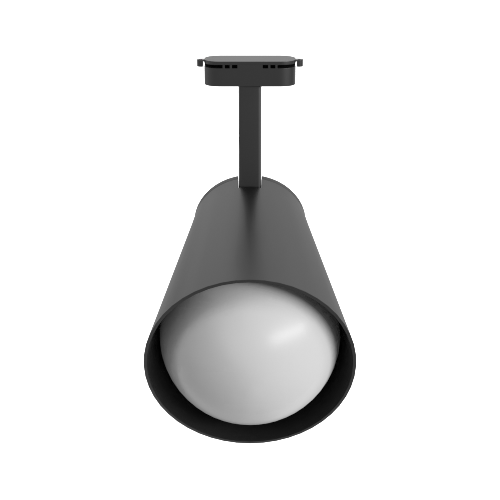

추천 아이템 Top10
추천 1순위 : 레일조명 그라시아 식탁등 카페조명 LED (화이트)


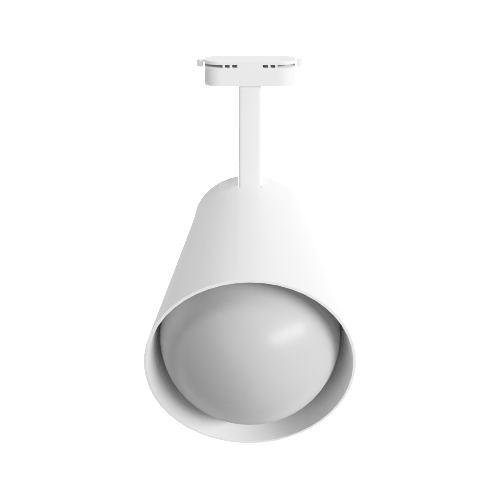

------------------------------------------------------------
추천 2순위 : LED 레일조명 그라시아 식탁등 카페조명 (스카이)


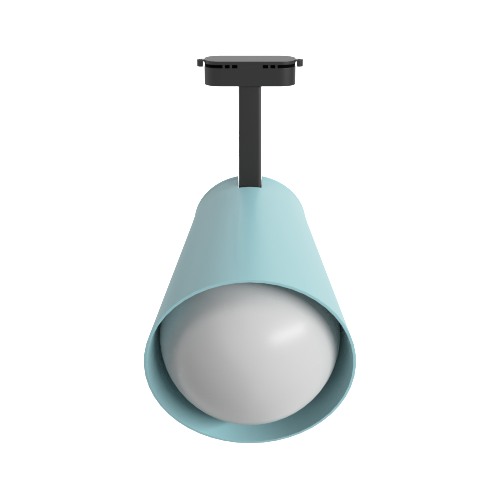

------------------------------------------------------------
추천 3순위 : LED 레일조명 그라시아 식탁등 카페조명 (로즈골드)


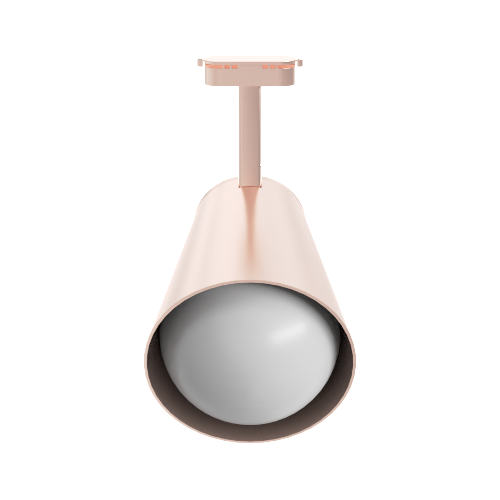

------------------------------------------------------------
추천 4순위 : 레일조명 GU10 원통 레일등 카페조명 매장조명 (블랙)


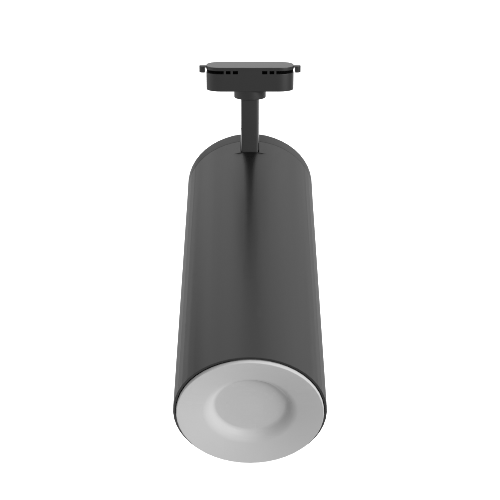

------------------------------------------------------------
추천 5순위 : 허드 원통 레일조명 4등 세트 (블랙)


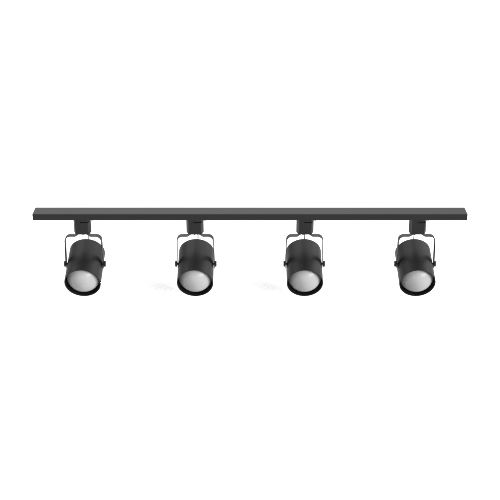

------------------------------------------------------------
추천 6순위 : 클로버체어 (블랙)


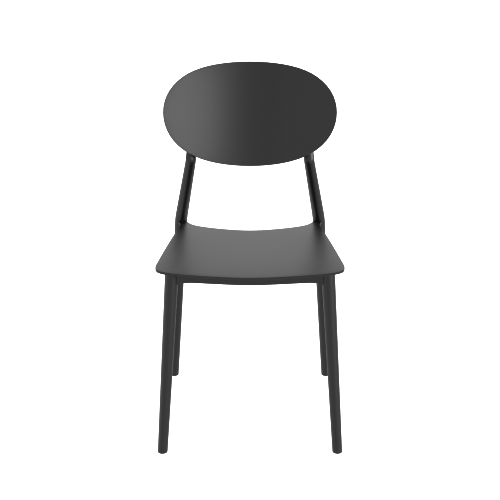

------------------------------------------------------------
추천 7순위 : 미드센츄리체어 (블랙)


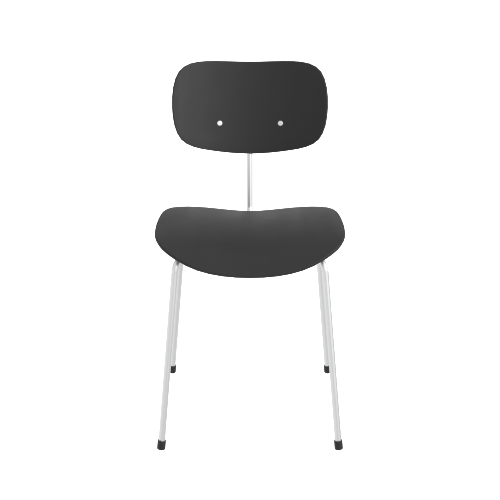

------------------------------------------------------------
추천 8순위 : Archisketch Standard Curtain
이미지 없음

------------------------------------------------------------
추천 9순위 : 무소음모던블랙스탠드시계 (블랙)


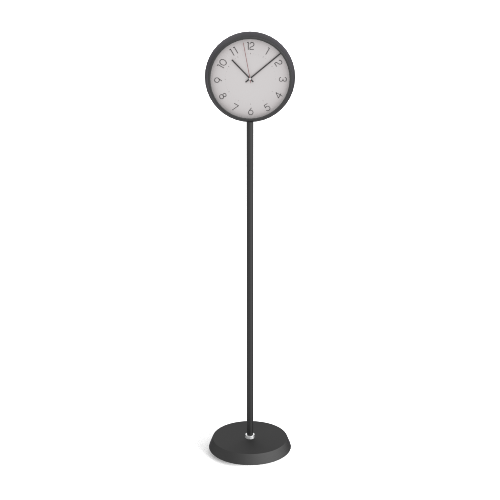

------------------------------------------------------------
추천 10순위 : 세레나 벨벳의자 (그레이+골드)


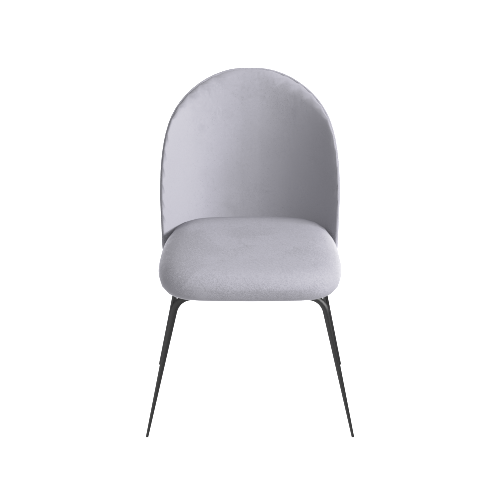

------------------------------------------------------------


In [186]:
prod = "레일조명 그라시아 식탁등 카페조명 LED (블랙)"
search_engine_b.search_product(prod, topn=10)

In [187]:
search_engine_b.result

,index,product_id,name,new_tag,projectId,images,similarity
0,36598,XvJtJW9FB3B19EEE6E84C20,레일조명 그라시아 식탁등 카페조명 LED (화이트),modern minimal natural 휴빛조명 레일조명 그라시아 식탁등 카페조명...,X82Tx47493B5C3CA33D4A9B,[https://resources.archisketch.com/product/XvJ...,0.818182
1,44925,XvJtJW7F7B89280928C48C1,LED 레일조명 그라시아 식탁등 카페조명 (스카이),modern minimal scandinavian 휴빛조명 led 레일조명 그라시아...,X58m9-rE477A9FB43F944CC,[https://resources.archisketch.com/product/XvJ...,0.727273
2,46121,XvJtJW7BFAAB35F00B64175,LED 레일조명 그라시아 식탁등 카페조명 (로즈골드),modern vintage korean_and_asian 휴빛조명 led 레일조명 ...,X48rlVB67EF4EED50794F78,[https://resources.archisketch.com/product/XvJ...,0.636364
3,44824,XvJtJXB036968A58C2B4C85,레일조명 GU10 원통 레일등 카페조명 매장조명 (블랙),modern natural minimal 공간led 레일조명 gu10 원통 레일등 ...,X586a_AE3F99C2A00784613,[https://resources.archisketch.com/product/XvJ...,0.521739
4,26400,XvJtJW4185EB9D477654B59,허드 원통 레일조명 4등 세트 (블랙),modern natural minimal 투플레이스 허드 원통 레일조명 4등 세트 ...,X9TbYyNEAFBAAB0E194408C,[https://resources.archisketch.com/product/XvJ...,0.454545
5,46569,XxzI_YU21845C38CA114C71,클로버체어 (블랙),modern natural minimal 로엠가구 클로버체어 (블랙) x3ws61a...,X3WS61aC3C84565BA5F4CC8,[https://resources.archisketch.com/product/Xxz...,0.444444
6,25183,XvJtJVl0B7CD6E5E2334849,미드센츄리체어 (블랙),modern minimal natural 플랜트란스 미드센츄리체어 (블랙) x9vx...,X9VX0KWFDC7FB10E875486F,[https://resources.archisketch.com/product/XvJ...,0.444444
7,918,1F631AD4C32C4109,Archisketch Standard Curtain,modern natural minimal archisketch standard cu...,X8QStBVB4FDB8D436544C6E,[],0.444444
8,26138,XvJtJXG251F72EC213B470D,무소음모던블랙스탠드시계 (블랙),modern minimal natural 스위트하트 무소음모던블랙스탠드시계 (블랙)...,X9VIhb6A1EAB5114A1141AE,[https://resources.archisketch.com/product/XvJ...,0.444444
9,913,Xz-wAD73DDDB96189464AD0,세레나 벨벳의자 (그레이+골드),modern natural minimal 리바트 세레나 벨벳의자 (그레이+골드) x...,X8QStBVB4FDB8D436544C6E,[https://resources.archisketch.com/product/Xz-...,0.421053
